# IPO Prospectus Data Exploration and Analysis

## Goal
Use the IPO Prospectus data to create a model that predicts whether a company will have a successful IPO or not.

## Data

Acquired from scraping thousands of SEC prospectus documents. The data was stored in HTML format, and then converted to a CSV file. Things like keywords, underwriting, and financial data were extracted from the HTML and stored in new columns. 


## Preprocessing Data

Applying the fundamental rules of data cleaning and feature engineering to the data.

In [85]:
import pandas as pd
import numpy as np
import warnings
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
warnings.filterwarnings('ignore')

## Allow full log display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

def create_original_dataframe():
    original_df = pd.read_csv('../data/all_financial_with_keywords.csv') 
    original_df = original_df.drop_duplicates()
    return original_df

original_df = create_original_dataframe()

### Prep Target Column
def prep_target_variable(original_df, column='diff'):
    # Convert to percent based deltas
    original_df['open'] = original_df[column] + original_df['close']
    original_df['diff_percent'] = original_df[column] / original_df['close']
    
   # Remove the over 100% change values
    final_df = original_df[(original_df['diff_percent'] > -1.0) & (original_df['diff_percent'] < 1.0)]
    return final_df

original_df = prep_target_variable(original_df)
target_column = 'diff_percent'

bank_columns = [
    'citigroup', 'citi', 'morgan stanley', 'ubs', 'barclays', 'wells fargo', 
    'goldman sachs', 'deutsche bank', 'credit suisse', 'merrill lynch', 
    'rbc capital', 'jefferies', 'stifel', 'morgan stanley.1', 'merrill lynch.1', 
    'goldman sachs.1', 'raymond james', 'piper jaffray', 'robert w. baird', 
    'william blair', 'william blair.1', 'hill road', 'document_length', 'word_count'
]

keyword_columns = [
    'technology', 'software', 'ai', 'machine learning', 'cloud', 'saas', 
    'platform', 'digital', 'data', 'analytics', 'algorithm', 'automation', 
    'blockchain', 'cryptocurrency', 'cybersecurity', 'subscription', 'recurring',
    'e-commerce', 'mobile', 'app', 'virtual', 'healthcare', 'biotech', 
    'pharmaceutical', 'medical', 'clinical', 'energy', 'renewable', 'solar', 
    'electric', 'battery', 'real estate', 'logistics', 'transportation', 
    'automotive', 'document_length', 'word_count' 
]

financial_columns = [
    'additional_paid_in_capital_trend', 'additional_paid_in_capital_recent',
    'total_assets_trend', 'total_assets_recent', 'total_current_liabilities_trend', 
    'total_current_liabilities_recent', 'total_liabilities_trend', 'total_liabilities_recent', 
    'cash_trend', 'cash_recent', 'total_capitalization_trend', 'total_capitalization_recent', 
    'total_current_assets_trend', 'total_current_assets_recent', 'volume', 
    'close', 'diff', 'price_public_total', 'public_price_per_share_x', 
    'public_price_per_share_y' 
]

In [86]:
import numpy as np

def prepare_bank_count_feature(df, columns):
    # Make a copy to avoid modifying the original
    df = df.copy()
    
    ### Convert NA to 0
    df[columns] = df[columns].fillna(0)

    ### Remove Dupes
    dupes = [
        'morgan stanley.1',
        'merrill lynch.1',
        'goldman sachs.1',
        'william blair.1'
    ]

    for dupe in dupes:
        # Fix: Check if column exists in the subset
        if dupe not in df[columns].columns:
            continue
        root_name = dupe.split('.')[0]
        # Fix: Work directly with the main dataframe
        df[root_name] = df[root_name] + df[dupe]
        df = df.drop(dupe, axis=1)
        # Update columns list to reflect dropped column
        if dupe in columns:
            columns = [col for col in columns if col != dupe]
        
    ### Feature Engineer Bank Group Column
    cols = list(df[columns].columns)
    # Fix: Add new column to main dataframe, not subset
    df['bank_group'] = df[columns].apply(
        lambda row: [col for col, val in row.items() 
                    if val >= 1 and col != 'word_count' and col != 'document_length'], 
        axis=1
    )
    # Encoded value of bank name is its index in the cols list 
    df['bank_group'] = df['bank_group'].apply(
        lambda row: [cols.index(bank_name) for bank_name in row]
    )

    ### Feature Engineer Unique Bank Count
    df['unique_bank_count'] = df['bank_group'].apply(lambda row: len(row))

    ### Feature Engineer Bank Count Ratios
    for col in df[columns].columns:
        if col in ['bank_group', 'word_count', 'document_length', 'unique_bank_count']:
            continue
        new_col = f'{col}-word-count-ratio'
        df[new_col] = df[col] / df['word_count']

    ### Feature Engineer Parallel Log1p Column
    for col in df[columns].columns:
        if col in ['bank_group', 'word_count', 'document_length', 'unique_bank_count'] or 'word-count-ratio' in col:
            continue
        new_col = f'{col}-log1p'
        df[new_col] = np.log1p(df[col])   

    return df


import numpy as np

def prepare_keyword_count_feature(df, columns):
    # Make a copy to avoid modifying the original
    df = df.copy()
    
    ### Convert NA to 0
    df[columns] = df[columns].fillna(0)
        
    ### Feature Engineer Keyword Group Column
    cols = list(df[columns].columns)
    # Remove non-keyword columns, check if column has a value
    df['keyword_group'] = df[columns].apply(
        lambda row: [col for col, val in row.items() 
                    if val >= 1 and col != 'word_count' and col != 'document_length'], 
        axis=1
    )
    # Encoded value of keyword name is its index in the cols list 
    df['keyword_group'] = df['keyword_group'].apply(
        lambda row: [cols.index(keyword_name) for keyword_name in row]
    )

    ### Feature Engineer Unique Keyword Count
    # Count the length of the keyword_groups array
    df['unique_keyword_count'] = df['keyword_group'].apply(lambda row: len(row))

    ### Feature Engineer Keyword Count Ratios
    for col in df[columns].columns:
        if col in ['keyword_group', 'word_count', 'document_length', 'unique_keyword_count']:
            continue
        new_col = f'{col}-word-count-ratio'
        # Fix: Reference the main dataframe for both numerator and denominator
        df[new_col] = df[col] / df['word_count']

    ### Feature Engineer Parallel Log1p Column
    for col in df[columns].columns:
        if col in ['keyword_group', 'word_count', 'document_length', 'unique_keyword_count'] or 'word-count-ratio' in col:
            continue
        new_col = f'{col}-log1p'
        # Fix: Reference the main dataframe
        df[new_col] = np.log1p(df[col])   

    return df


def prepare_financial_feature(df, columns):
    ### Calculate computed columns
    def safe_ratio(numerator, denominator, fill_value=np.nan):
        return np.where(denominator != 0, numerator / denominator, fill_value)

    # Make a copy to avoid modifying the original
    df = df.copy()
    
    ### Remove dupes and unused columns
    # Work directly with the main dataframe for structural changes
    df = df.drop("public_price_per_share_x", axis=1, errors="ignore")
    df = df.rename(columns={"public_price_per_share_y": "public_price_per_share"})
    df = df.drop("close", axis=1, errors="ignore")
    df = df.drop("volume", axis=1, errors="ignore")
    
    # Update columns list to reflect any dropped columns
    columns = [col for col in columns if col in df.columns]
    # Add the renamed column if it exists
    if "public_price_per_share" in df.columns and "public_price_per_share" not in columns:
        columns.append("public_price_per_share")

    ### Normalize
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[columns])
    # Fix: Assign back to the main dataframe with proper index alignment
    df[columns] = pd.DataFrame(scaled_data, columns=columns, index=df.index)

    ### Missing data flag
    df[columns] = df[columns].fillna(0)
    # Fix: Add new column to main dataframe
    df['missing_financials'] = (df[columns] == 0).sum(axis=1)
    # Note: Removed the .value_counts() as it doesn't assign to anything

    ### Calculate change percentages
    for col in df[columns].columns:
        if col.endswith('_trend'):
            first_col = col.replace('_trend', '_first')
            recent_col = col.replace('_trend', '_recent')
            change_col = col.replace('_trend', '_change')
            
            # Fix: Add new columns to main dataframe
            df[first_col] = df[recent_col] - df[col]
            df[change_col] = safe_ratio(df[col], df[first_col])

    
    # Fix: Add new columns to main dataframe, not subset
    df['asset_to_liability_ratio'] = safe_ratio(
        df['total_assets_recent'], 
        df['total_liabilities_recent']
    )

    df['liability_to_capital_ratio'] = safe_ratio(
        df['total_liabilities_recent'], 
        df['total_capitalization_recent']
    )

    df['asset_to_capital_ratio'] = safe_ratio(
        df['total_assets_recent'], 
        df['total_capitalization_recent']
    )

    df['liability_to_assets_ratio'] = safe_ratio(
        df['total_liabilities_recent'], 
        df['total_assets_recent']
    )

    df['assets_to_public_price_ratio'] = safe_ratio(
        df['total_assets_recent'], 
        df['public_price_per_share']
    )

    df['liabilities_to_public_price_ratio'] = safe_ratio(
        df['total_liabilities_recent'], 
        df['public_price_per_share']
    )

    return df

cleaned_df = prepare_bank_count_feature(original_df, bank_columns)
cleaned_df = prepare_keyword_count_feature(cleaned_df, keyword_columns)
cleaned_df = prepare_financial_feature(cleaned_df, financial_columns)

## Convert Dates to numeric
cleaned_df['ipo_date'] = pd.to_datetime(cleaned_df['ipo_date'])
cleaned_df['ipo_day'] = cleaned_df['ipo_date'].dt.day
cleaned_df['ipo_month'] = cleaned_df['ipo_date'].dt.month
cleaned_df['ipo_year'] = cleaned_df['ipo_date'].dt.year

### Drop String columns and unused
cleaned_df.drop('symbol', axis=1, inplace=True, errors='ignore')
cleaned_df.drop('url', axis=1, inplace=True, errors='ignore')
cleaned_df.drop('ipo_date', axis=1, inplace=True, errors='ignore')
cleaned_df.drop('day', axis=1, inplace=True, errors='ignore')
cleaned_df.drop('close', axis=1, inplace=True, errors='ignore')
cleaned_df.drop('volume', axis=1, inplace=True, errors='ignore')
cleaned_df.drop('diff', axis=1, inplace=True, errors='ignore')
cleaned_df.drop('open', axis=1, inplace=True, errors='ignore')

## Transform to one-hot encoded
mlb_bank = MultiLabelBinarizer()
mlb_keyword = MultiLabelBinarizer()

# Encode bank_group
encoded_bank_group = mlb_bank.fit_transform(cleaned_df['bank_group'])
bank_df = pd.DataFrame(
    encoded_bank_group,
    columns=[f'bank_group_{group}' for group in mlb_bank.classes_],
    index=cleaned_df.index
)

# Encode keyword_group
encoded_keyword_group = mlb_keyword.fit_transform(cleaned_df['keyword_group'])
keyword_df = pd.DataFrame(
    encoded_keyword_group,
    columns=[f'keyword_group_{group}' for group in mlb_keyword.classes_],
    index=cleaned_df.index
)

# Drop original array columns
cleaned_df.drop(['bank_group', 'keyword_group'], axis=1, inplace=True)

# Concatenate all dataframes
cleaned_df = pd.concat([cleaned_df, bank_df, keyword_df], axis=1)

cleaned_df.to_csv('../data/processed_data.csv', index=False)

In [87]:
df = pd.read_csv('../data/processed_data.csv')
df.head()

,additional_paid_in_capital_trend,additional_paid_in_capital_recent,total_assets_trend,total_assets_recent,total_current_liabilities_trend,total_current_liabilities_recent,total_liabilities_trend,total_liabilities_recent,cash_trend,cash_recent,total_capitalization_trend,total_capitalization_recent,total_current_assets_trend,total_current_assets_recent,technology,software,ai,machine learning,cloud,saas,platform,digital,data,analytics,algorithm,automation,blockchain,cryptocurrency,cybersecurity,subscription,recurring,e-commerce,mobile,app,virtual,healthcare,biotech,pharmaceutical,medical,clinical,energy,renewable,solar,electric,battery,real estate,logistics,transportation,automotive,citigroup,citi,morgan stanley,ubs,barclays,price_public_total,raymond james,piper jaffray,wells fargo,merrill lynch,rbc capital,eli lilly,credit suisse,stifel,jefferies,hill road,robert w. baird,william blair,goldman sachs,deutsche bank,davis polk,public_price_per_share,document_length,word_count,diff_percent,unique_bank_count,citigroup-word-count-ratio,citi-word-count-ratio,morgan stanley-word-count-ratio,ubs-word-count-ratio,barclays-word-count-ratio,wells fargo-word-count-ratio,goldman sachs-word-count-ratio,deutsche bank-word-count-ratio,credit suisse-word-count-ratio,merrill lynch-word-count-ratio,rbc capital-word-count-ratio,jefferies-word-count-ratio,stifel-word-count-ratio,raymond james-word-count-ratio,piper jaffray-word-count-ratio,robert w. baird-word-count-ratio,william blair-word-count-ratio,hill road-word-count-ratio,citigroup-log1p,citi-log1p,morgan stanley-log1p,ubs-log1p,barclays-log1p,wells fargo-log1p,goldman sachs-log1p,deutsche bank-log1p,credit suisse-log1p,merrill lynch-log1p,rbc capital-log1p,jefferies-log1p,stifel-log1p,raymond james-log1p,piper jaffray-log1p,robert w. baird-log1p,william blair-log1p,hill road-log1p,unique_keyword_count,technology-word-count-ratio,software-word-count-ratio,ai-word-count-ratio,machine learning-word-count-ratio,cloud-word-count-ratio,saas-word-count-ratio,platform-word-count-ratio,digital-word-count-ratio,data-word-count-ratio,analytics-word-count-ratio,algorithm-word-count-ratio,automation-word-count-ratio,blockchain-word-count-ratio,cryptocurrency-word-count-ratio,cybersecurity-word-count-ratio,subscription-word-count-ratio,recurring-word-count-ratio,e-commerce-word-count-ratio,mobile-word-count-ratio,app-word-count-ratio,virtual-word-count-ratio,healthcare-word-count-ratio,biotech-word-count-ratio,pharmaceutical-word-count-ratio,medical-word-count-ratio,clinical-word-count-ratio,energy-word-count-ratio,renewable-word-count-ratio,solar-word-count-ratio,electric-word-count-ratio,battery-word-count-ratio,real estate-word-count-ratio,logistics-word-count-ratio,transportation-word-count-ratio,automotive-word-count-ratio,technology-log1p,software-log1p,ai-log1p,machine learning-log1p,cloud-log1p,saas-log1p,platform-log1p,digital-log1p,data-log1p,analytics-log1p,algorithm-log1p,automation-log1p,blockchain-log1p,cryptocurrency-log1p,cybersecurity-log1p,subscription-log1p,recurring-log1p,e-commerce-log1p,mobile-log1p,app-log1p,virtual-log1p,healthcare-log1p,biotech-log1p,pharmaceutical-log1p,medical-log1p,clinical-log1p,energy-log1p,renewable-log1p,solar-log1p,electric-log1p,battery-log1p,real estate-log1p,logistics-log1p,transportation-log1p,automotive-log1p,missing_financials,additional_paid_in_capital_first,additional_paid_in_capital_change,total_assets_first,total_assets_change,total_current_liabilities_first,total_current_liabilities_change,total_liabilities_first,total_liabilities_change,cash_first,cash_change,total_capitalization_first,total_capitalization_change,total_current_assets_first,total_current_assets_change,asset_to_liability_ratio,liability_to_capital_ratio,asset_to_capital_ratio,liability_to_assets_ratio,assets_to_public_price_ratio,liabilities_to_public_price_ratio,ipo_day,ipo_month,ipo_year,bank_group_0,bank_group_1,bank_group_2,bank_group_3,bank_group_4,bank_group_5,bank_group_6

## Hypothesis Test: IPO's Perform Better in the Fall

Null Hypothesis: The Fall is not a significant factor
Alternative Hypothesis: IPO's Perform Better in the Fall

In [88]:
# Define fall months (September=9, October=10, November=11)
df['is_fall'] = df['ipo_month'].isin([9, 10, 11])

# Create fall vs non-fall groups
fall_performance = df[df['is_fall'] == True]['diff_percent']
non_fall_performance = df[df['is_fall'] == False]['diff_percent']


### Basic EDA

Fall IPO Performance:
Count: 484
Mean: -0.02%
Median: -0.00%
Std: 0.13%

Non-Fall IPO Performance:
Count: 1445
Mean: -0.01%
Median: 0.00%
Std: 0.15%


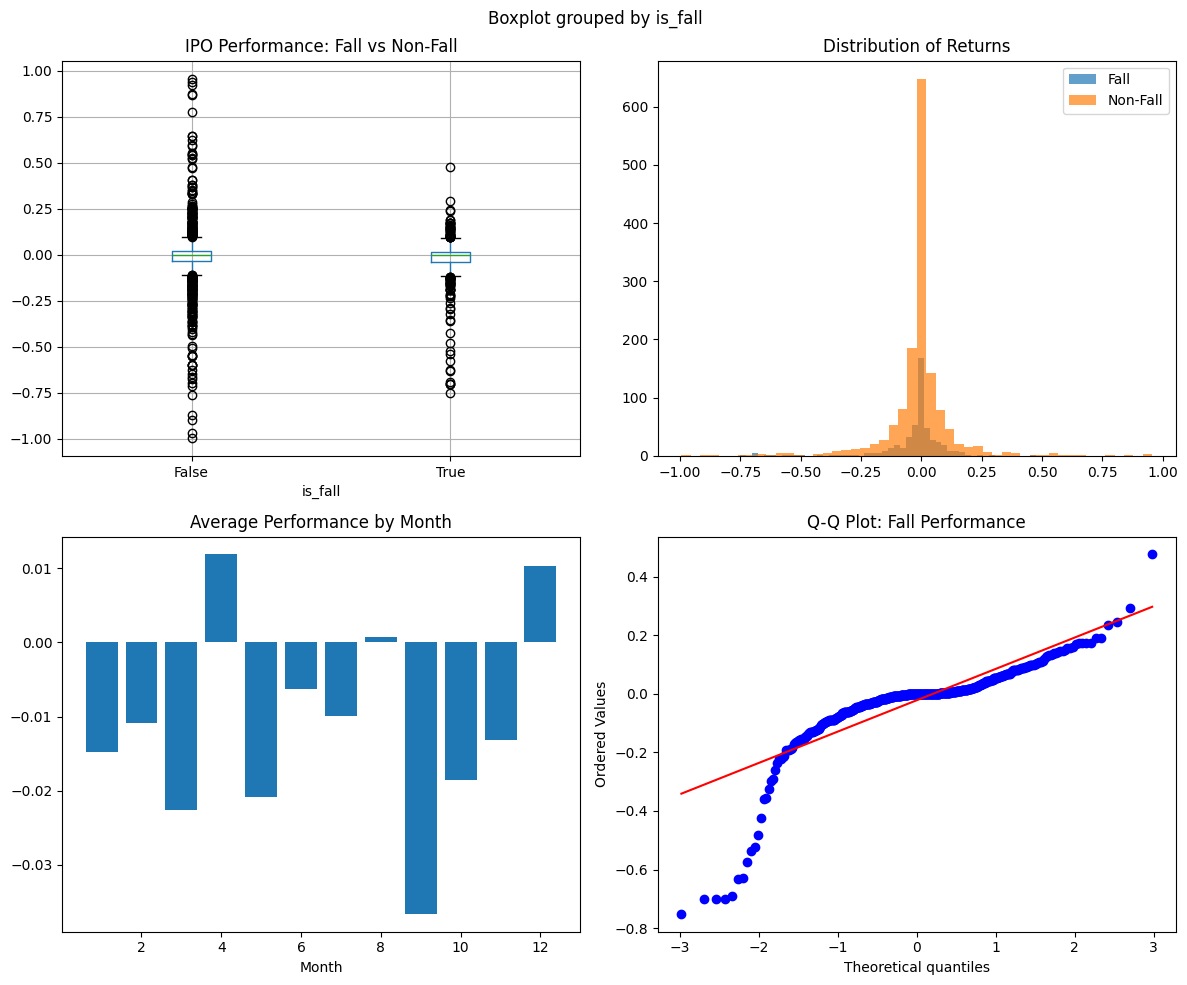

In [90]:
# Basic statistics
print("Fall IPO Performance:")
print(f"Count: {len(fall_performance)}")
print(f"Mean: {fall_performance.mean():.2f}%")
print(f"Median: {fall_performance.median():.2f}%")
print(f"Std: {fall_performance.std():.2f}%")

print("\nNon-Fall IPO Performance:")
print(f"Count: {len(non_fall_performance)}")
print(f"Mean: {non_fall_performance.mean():.2f}%")
print(f"Median: {non_fall_performance.median():.2f}%")
print(f"Std: {non_fall_performance.std():.2f}%")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Box plot
df.boxplot(column='diff_percent', by='is_fall', ax=axes[0,0])
axes[0,0].set_title('IPO Performance: Fall vs Non-Fall')

# Histograms
axes[0,1].hist(fall_performance, alpha=0.7, label='Fall', bins=50)
axes[0,1].hist(non_fall_performance, alpha=0.7, label='Non-Fall', bins=50)
axes[0,1].legend()
axes[0,1].set_title('Distribution of Returns')

# Monthly breakdown
monthly_stats = df.groupby('ipo_month')['diff_percent'].agg(['mean', 'count'])
axes[1,0].bar(monthly_stats.index, monthly_stats['mean'])
axes[1,0].set_title('Average Performance by Month')
axes[1,0].set_xlabel('Month')

# Q-Q plots for normality check
stats.probplot(fall_performance, dist="norm", plot=axes[1,1])
axes[1,1].set_title('Q-Q Plot: Fall Performance')

plt.tight_layout()
plt.show()

### Formal Hypotheses

- H0: μ_fall ≤ μ_non_fall (Fall IPOs do not perform better)

- H1: μ_fall > μ_non_fall (Fall IPOs perform better)

### Check for normal distribution

In [92]:
# Test for normality
shapiro_fall = stats.shapiro(fall_performance.sample(min(5000, len(fall_performance))))
shapiro_non_fall = stats.shapiro(non_fall_performance.sample(min(5000, len(non_fall_performance))))

print(f"Shapiro-Wilk test for Fall: p-value = {shapiro_fall.pvalue:.6f}")
print(f"Shapiro-Wilk test for Non-Fall: p-value = {shapiro_non_fall.pvalue:.6f}")

# Test for equal variances
levene_stat, levene_p = stats.levene(fall_performance, non_fall_performance)
print(f"Levene's test for equal variances: p-value = {levene_p:.6f}")

Shapiro-Wilk test for Fall: p-value = 0.000000
Shapiro-Wilk test for Non-Fall: p-value = 0.000000
Levene's test for equal variances: p-value = 0.212936


### Normal distribution violation, use Mann-Whitney U test

In [93]:
# Significance level
alpha = 0.05

# Since data is not normal, use Mann-Whitney U test
test_stat, p_value = stats.mannwhitneyu(fall_performance, non_fall_performance, 
                                      alternative='greater')

print(f"Mann-Whitney U Test Results:")
print(f"Test statistic (U): {test_stat:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Alpha: {alpha}")

# Decision
if p_value < alpha:
    decision = "Reject H0"
    conclusion = "Fall IPOs perform significantly better than non-fall IPOs"
else:
    decision = "Fail to reject H0"
    conclusion = "No significant evidence that fall IPOs perform better"

print(f"\nDecision: {decision}")
print(f"Conclusion: {conclusion}")


Mann-Whitney U Test Results:
Test statistic (U): 339667.0000
P-value: 0.827770
Alpha: 0.05

Decision: Fail to reject H0
Conclusion: No significant evidence that fall IPOs perform better


## Hypothesis Testing Conclusion

82% chance of observing this difference if there is truly no difference between fall and non-fall IPOs. This means there is weak evidence that fall IPOs perform better (Null Hypothesis rejected). Based on the basic EDA step, both fall and non-fall IPOs have a similar performance, so it is not clear that fall IPOs perform better.